In [1]:
!pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.4.2-cp311-cp311-linux_x86_64.whl
  Using cached Keras-2.4.3-py2.py3-none-any.whl.metadata (1.5 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.5.0 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.5.0


# Configuration

In [1]:
ROOT_DIR = "../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'Freehand_SCRNN'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

# Imports

In [2]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib

2025-05-31 00:38:53.378099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 00:38:53.378150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-31 00:38:53.379542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-31 00:38:53.391489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## Dataset in a pandas Dataframe

In [3]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [4]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [5]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.keras'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [6]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [7]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

## Build the Neural Network

In [8]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(165000, 2, 128)
[2, 128]


In [10]:
model = neural_networks.freehand_scrnn_v4(in_shp)

model.summary()

2025-05-31 00:40:09.682705: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 2)]          0         
                                                                 
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 batch_normalization (Batch  (None, 2, 128, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 2, 128, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 64, 16)         0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64, 16)         64    

### Train the model

In [11]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
from keras.layers import Permute
filepath = NEURAL_NETWORK_FILENAME

X_train = Permute((2, 1))(X_train)
X_test = Permute((2, 1))(X_test)

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


2025-05-31 00:40:42.547502: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-05-31 00:40:44.953767: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feee66a62b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-31 00:40:44.953809: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-31 00:40:44.962573: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748652045.107483    4631 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


146/146 [==============================] - 11s 23ms/step - loss: 1.8541 - val_loss: 5.6351
Epoch 2/100
146/146 [==============================] - 3s 17ms/step - loss: 1.4898 - val_loss: 7.5293
Epoch 3/100
146/146 [==============================] - 3s 19ms/step - loss: 1.4310 - val_loss: 5.5119
Epoch 4/100
146/146 [==============================] - 2s 17ms/step - loss: 1.4264 - val_loss: 10.0703
Epoch 5/100
146/146 [==============================] - 3s 19ms/step - loss: 1.3715 - val_loss: 4.2672
Epoch 6/100
146/146 [==============================] - 3s 19ms/step - loss: 1.3505 - val_loss: 1.3222
Epoch 7/100
146/146 [==============================] - 3s 19ms/step - loss: 1.3325 - val_loss: 1.2857
Epoch 8/100
146/146 [==============================] - 3s 19ms/step - loss: 1.3294 - val_loss: 1.2734
Epoch 9/100
146/146 [==============================] - 3s 19ms/step - loss: 1.3125 - val_loss: 1.2680
Epoch 10/100
146/146 [==============================] - 3s 18ms/step - loss: 1.3086 - val_lo

# Evaluate and Plot Model Performance

In [12]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

54/54 [==============================] - 1s 10ms/step - loss: 1.2401
1.240055799484253


## Loss

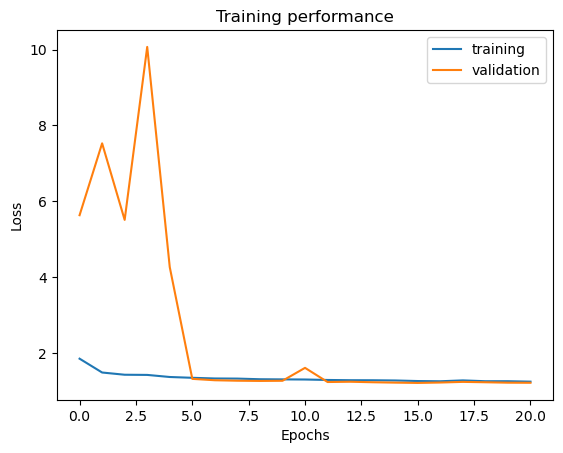

In [13]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

54/54 [==============================] - 1s 6ms/step


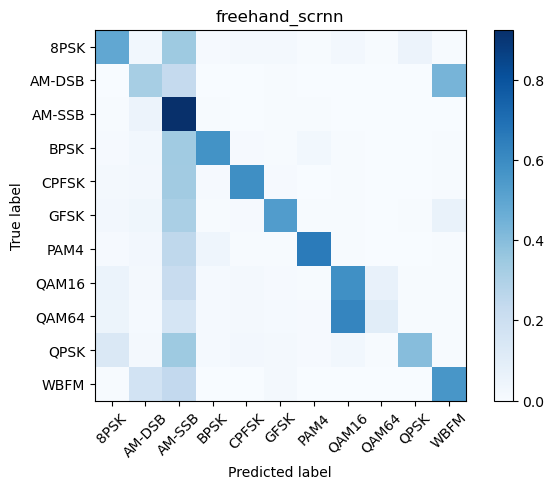

In [14]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

85/85 [==============================] - 1s 5ms/step
Overall Accuracy:  0.08803863298662705
85/85 [==============================] - 0s 5ms/step
Overall Accuracy:  0.09648798521256932
89/89 [==============================] - 0s 5ms/step
Overall Accuracy:  0.0911983032873807
89/89 [==============================] - 0s 5ms/step
Overall Accuracy:  0.10435699226985243
87/87 [==============================] - 0s 5ms/step
Overall Accuracy:  0.1217485549132948
88/88 [==============================] - 0s 5ms/step
Overall Accuracy:  0.1908342284282134
88/88 [==============================] - 0s 5ms/step
Overall Accuracy:  0.2522393407380867
86/86 [==============================] - 0s 4ms/step
Overall Accuracy:  0.3502906976744186
89/89 [==============================] - 0s 5ms/step
Overall Accuracy:  0.513667021654242
87/87 [==============================] - 0s 4ms/step
Overall Accuracy:  0.6412652767792955
87/87 [==============================] - 0s 5ms/step
Overall Accuracy:  0.73166303558460

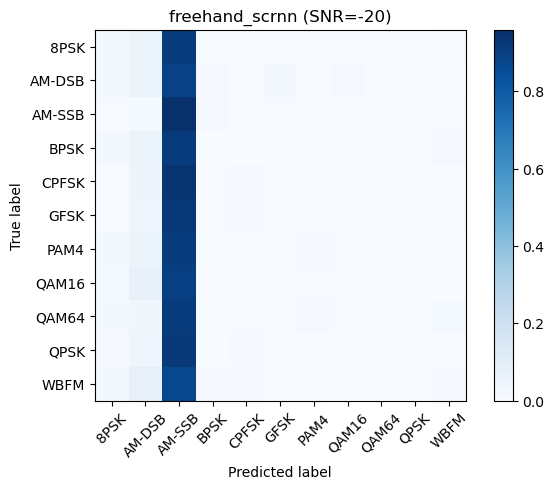

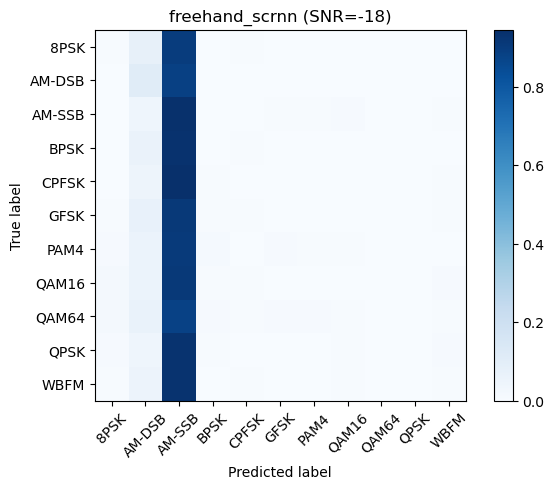

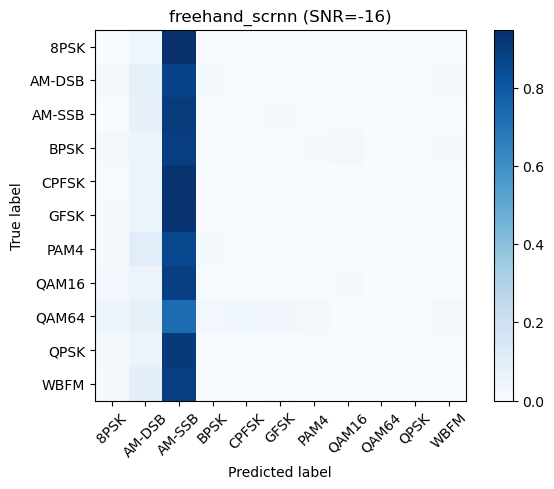

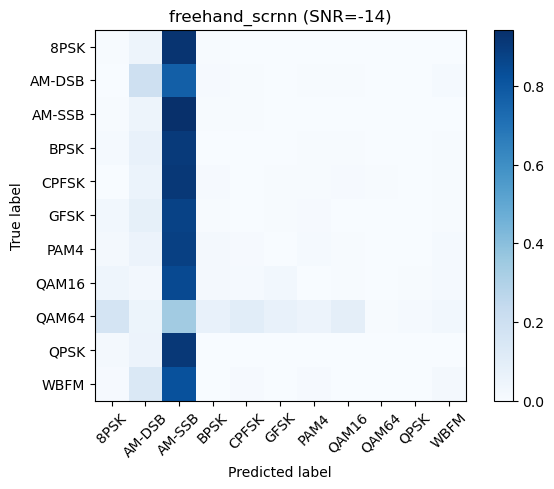

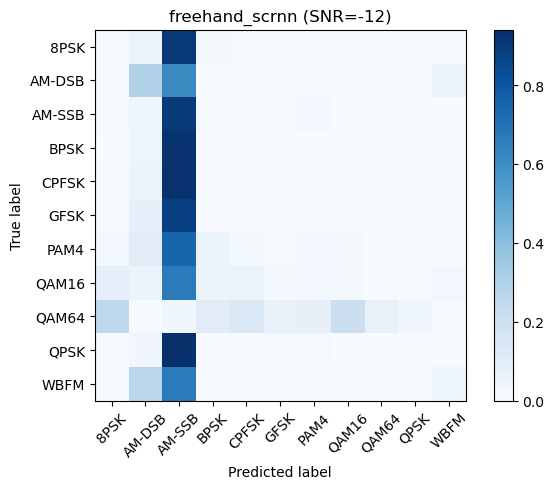

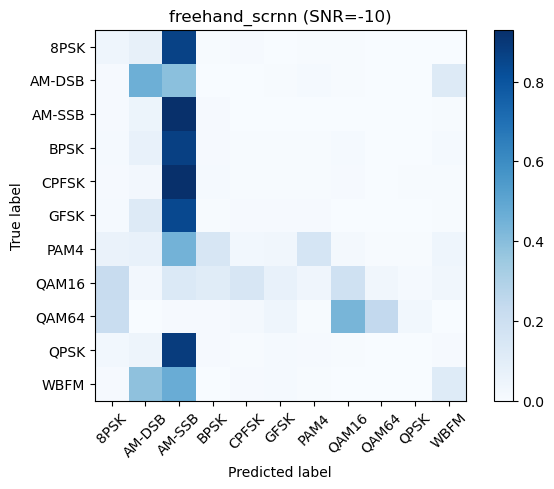

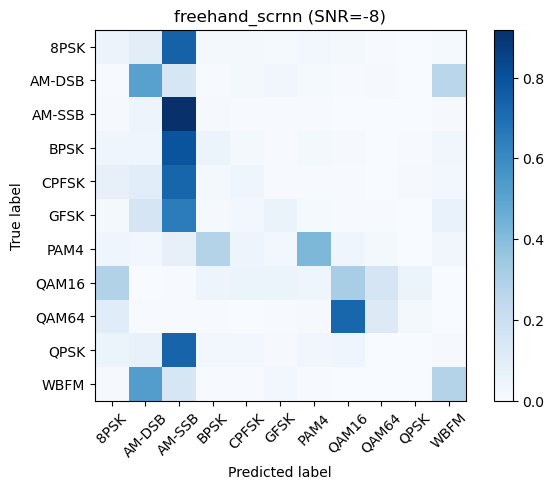

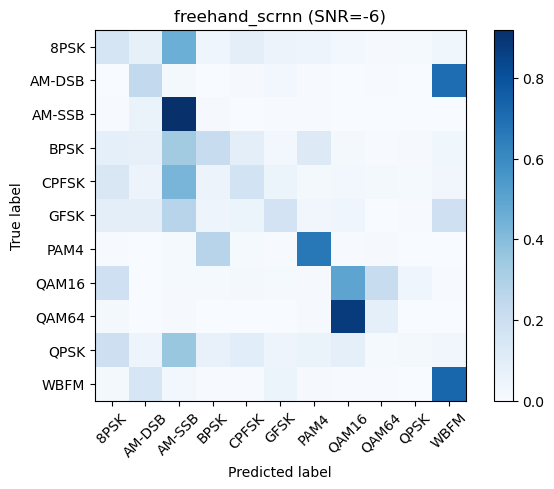

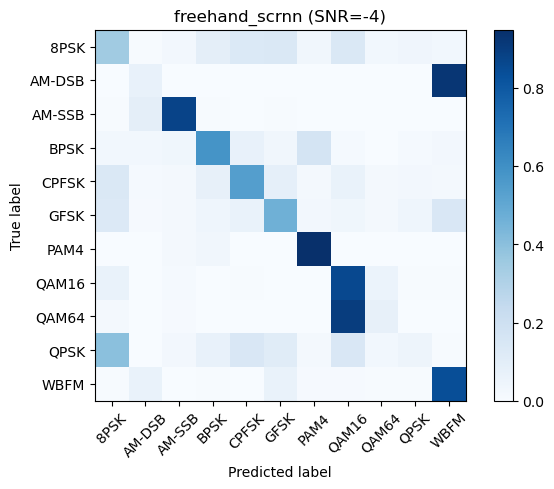

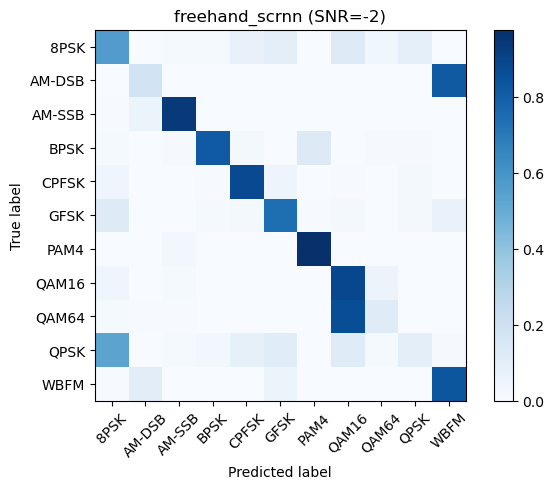

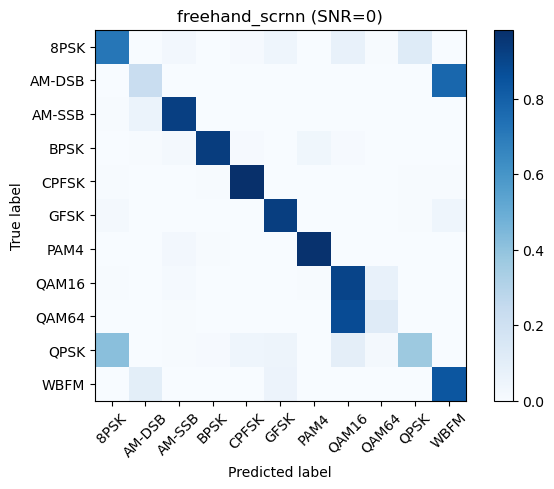

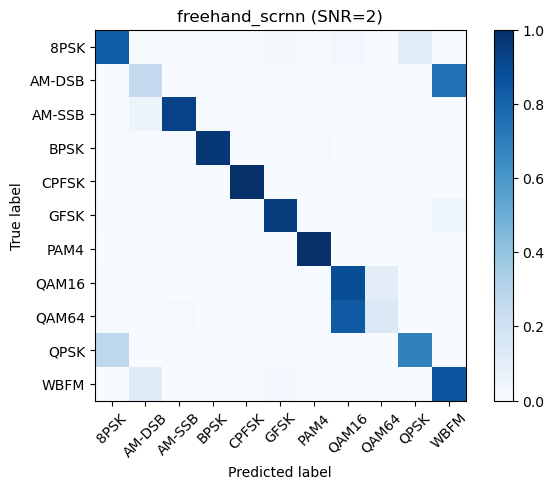

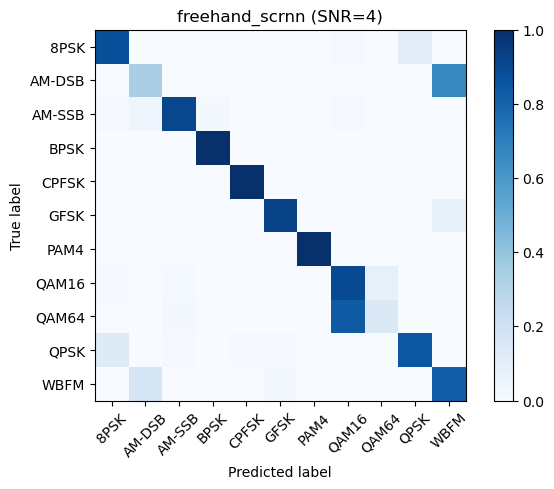

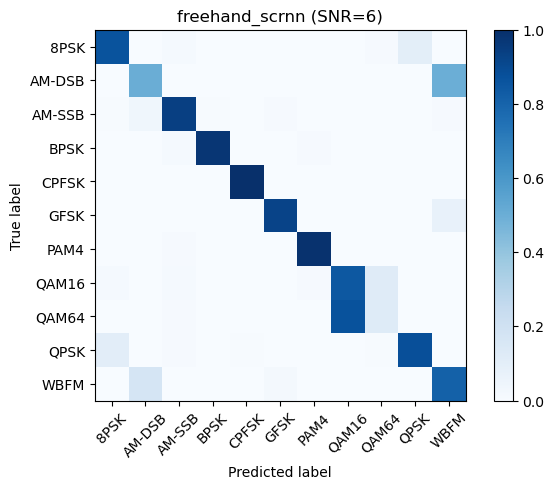

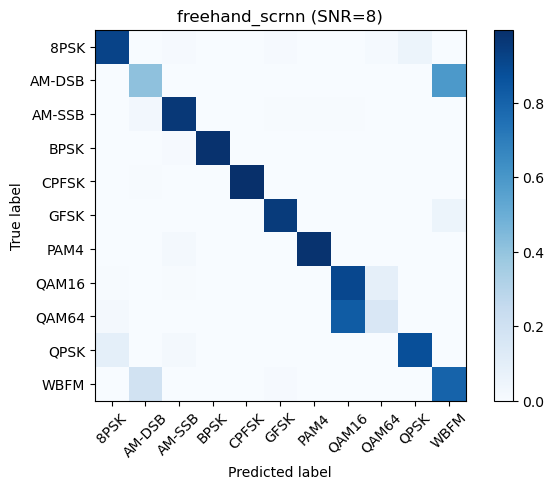

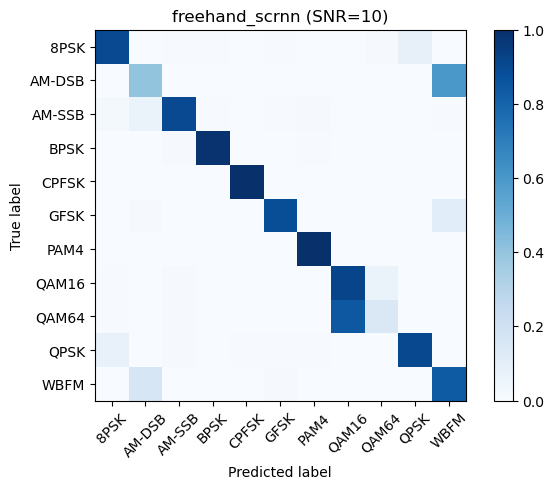

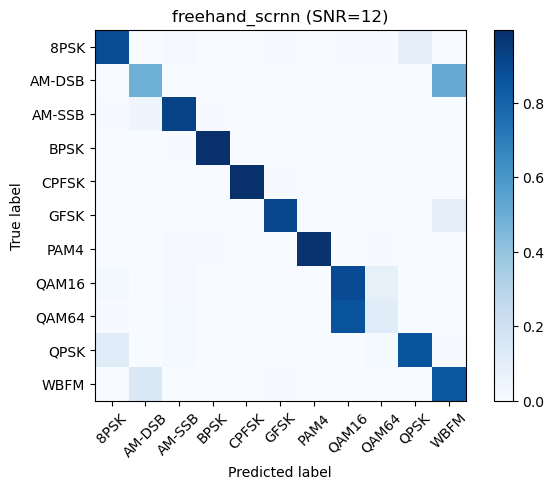

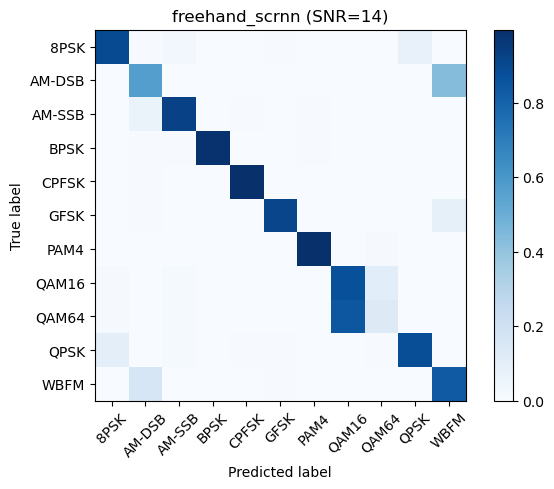

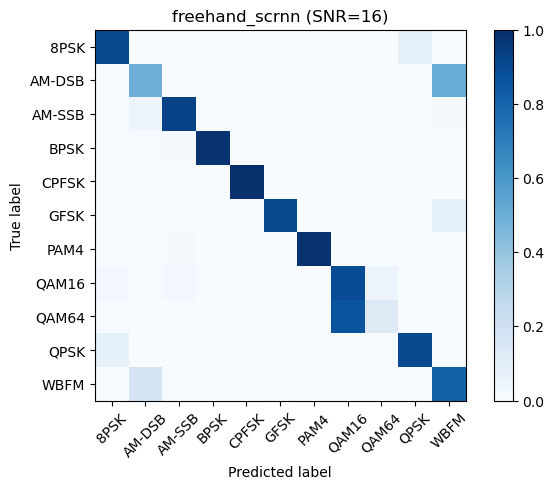

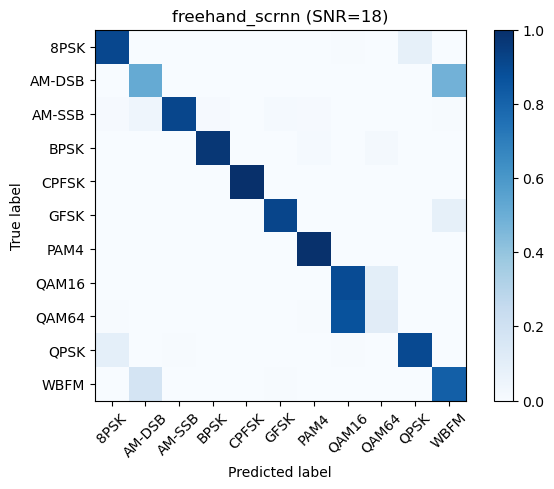

In [15]:
X_test = X_test.numpy() if hasattr(X_test, 'numpy') else X_test
Y_test = Y_test.numpy() if hasattr(Y_test, 'numpy') else Y_test

acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [16]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,9,10,12,19,25,35,51,64,73,77,79,80,81,80,80,82,80,80


In [19]:
# Save results to a pickle file for plotting later
# fd = open(OUTPUT_FILENAME,'wb')
# pickle.dump( ("CNN2", 0.5, acc) , fd )
# Save results to a pickle file for plotting later
import pickle

with open("Freehand_SCRNN_IQ_history.pkl", "wb") as f:
    pickle.dump(history.history, f)
    
OUTPUT_FILENAME = 'Freehand_SCRNN_IQ_acc.pkl'
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("Freehand_SCRNN_IQ", acc) , fd )

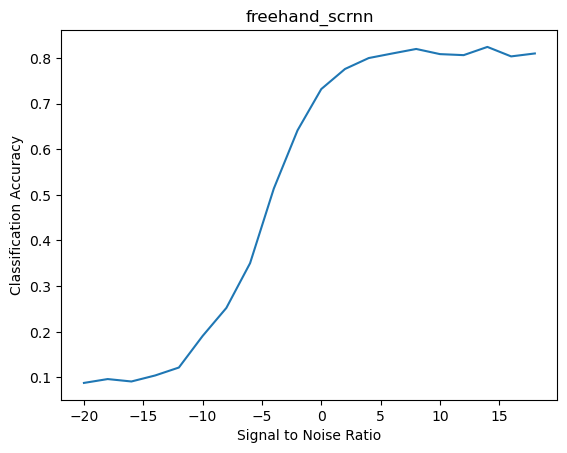

In [17]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)